In [79]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [80]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [81]:
np.random.seed(0)

# Otwieranie danych


In [82]:
with open('german-traffic-signs/train.p','rb') as file:
  train_data = pickle.load(file)
with open('german-traffic-signs/valid.p','rb') as file:
  valid_data = pickle.load(file)
with open('german-traffic-signs/test.p','rb') as file:
  test_data = pickle.load(file)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [83]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [84]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

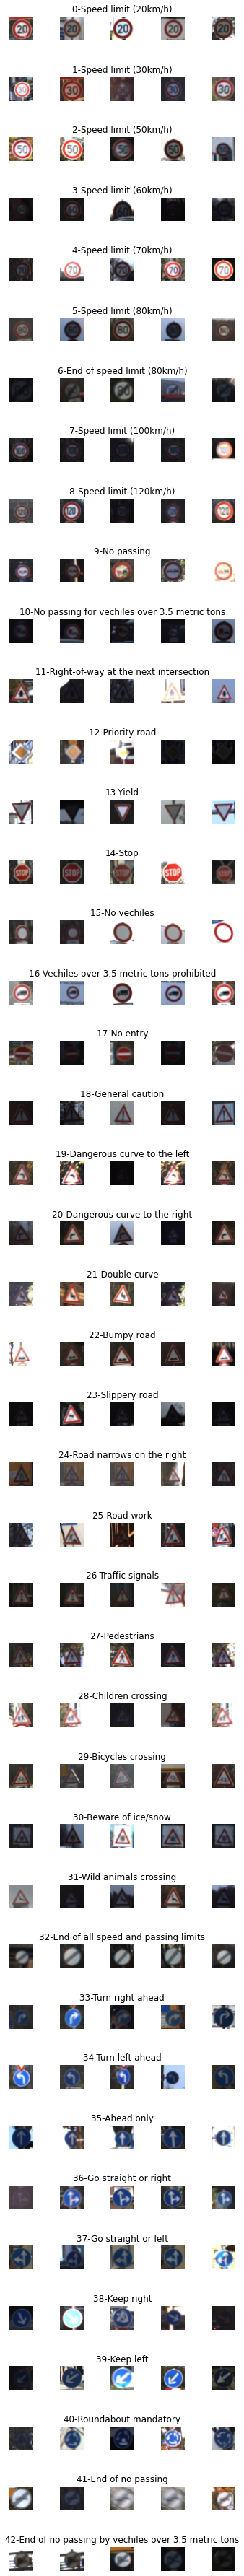

In [85]:
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + "-"+ row['SignName'])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


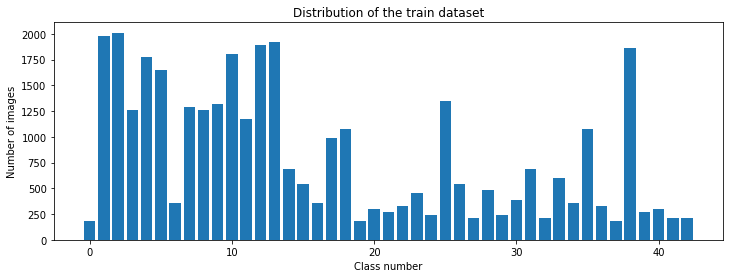

In [86]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


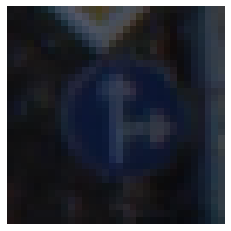

In [87]:
import cv2

plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

# Image Preprocesing


(32, 32)


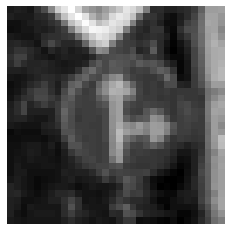

In [88]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap='gray')
plt.axis('off')
print(img.shape)

(32, 32)


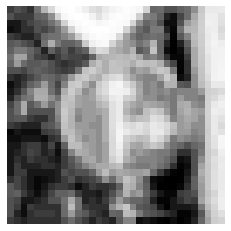

In [89]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis('off')
print(img.shape)

In [90]:
def preprocesing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocesing, X_train)))
X_val = np.array(list(map(preprocesing, X_val)))
X_test = np.array(list(map(preprocesing, X_test)))

(34799, 32, 32)


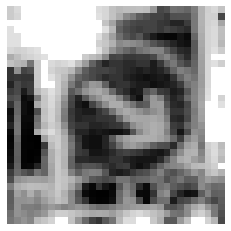

In [91]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)], cmap='gray')
plt.axis('off')
print(X_train.shape)

In [92]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

# Fit Generator



In [93]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range= 0.1, rotation_range=10)
datagen.fit(X_train)

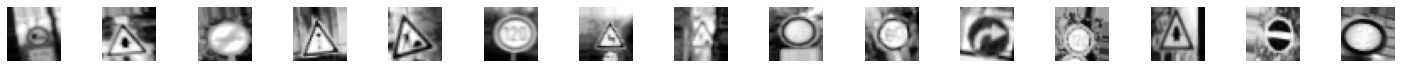

In [94]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axis = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axis[i].imshow(X_batch[i].reshape(32,32), cmap=plt.get_cmap('gray'))
  axis[i].axis('off')


In [95]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [96]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

# leNet Implementation

In [97]:
def leNet_model():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape = (32,32,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def modified_model():
    model = Sequential()
    model.add(Conv2D(60,(5,5), input_shape = (32,32,1), activation='relu'))
    model.add(Conv2D(60,(5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [98]:
model = modified_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

In [99]:
# history = model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

history = model.fit(datagen.flow(X_train, y_train, batch_size=50), epochs=10,validation_data=(X_val, y_val), verbose=1, shuffle=1)

Epoch 1/10
696/696 [==============================] - 16s 22ms/step - loss: 1.7724 - accuracy: 0.4980 - val_loss: 0.2966 - val_accuracy: 0.9032
Epoch 2/10
696/696 [==============================] - 16s 22ms/step - loss: 0.5810 - accuracy: 0.8222 - val_loss: 0.1628 - val_accuracy: 0.9544
Epoch 3/10
696/696 [==============================] - 16s 22ms/step - loss: 0.3519 - accuracy: 0.8911 - val_loss: 0.0944 - val_accuracy: 0.9698
Epoch 4/10
696/696 [==============================] - 15s 22ms/step - loss: 0.2685 - accuracy: 0.9198 - val_loss: 0.0797 - val_accuracy: 0.9751
Epoch 5/10
696/696 [==============================] - 15s 22ms/step - loss: 0.2207 - accuracy: 0.9316 - val_loss: 0.0639 - val_accuracy: 0.9816
Epoch 6/10
696/696 [==============================] - 15s 22ms/step - loss: 0.1920 - accuracy: 0.9418 - val_loss: 0.0558 - val_accuracy: 0.9844
Epoch 7/10
696/696 [==============================] - 15s 21ms/step - loss: 0.1622 - accuracy: 0.9510 - val_loss: 0.0536 - val_accuracy:

In [100]:
print(len(X_train))

34799


Text(0.5, 0, 'Epoch')

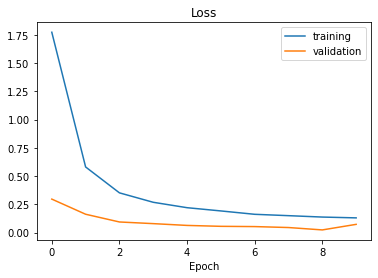

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title("Loss")
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

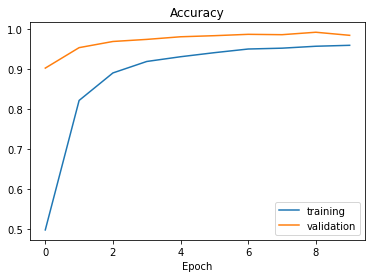

In [102]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title("Accuracy")
plt.xlabel('Epoch')

In [103]:
score = model.evaluate(X_test, y_test, verbose = 0 )
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

Test score:  0.17942838370800018
Test accuracy:  0.958511471748352


# Testing Image

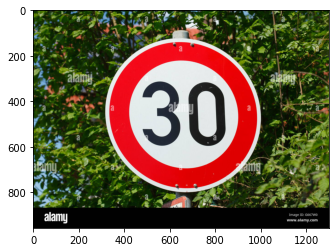

In [120]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


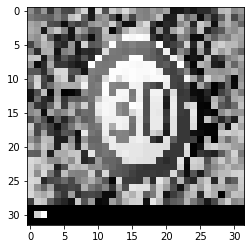

In [121]:
#Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocesing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [122]:
#Reshape reshape
img = img.reshape(1, 32, 32, 1)

In [123]:
#Test image
print("predicted sign: "+ str(np.argmax(model.predict(img), axis=1)))

1/1 [==============================] - 0s 18ms/step
predicted sign: [1]
